## MDSS SCAN ON AUTOSTRAT MODE 

Import the MDSS module and Bernoulli modules

In [1]:
import pandas as pd

import warnings
from time import perf_counter

from comp_metrics import odds_ratio
from pandas.api.types import is_numeric_dtype

warnings.filterwarnings('ignore')

### Data

In [2]:
compas = pd.read_csv('../datasets/studentinfo.csv').drop(columns = ['id_student', 'code_module', 'code_presentation'])
compas['final_result'] = compas['final_result'].isin(['Withdrawn', 'Failed']).astype(int)
compas

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,0
1,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,0
2,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,1
3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,0
4,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,0
...,...,...,...,...,...,...,...,...,...
32588,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,0
32589,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,0
32590,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,0
32591,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,1


In [3]:
compas.nunique()

gender                   2
region                  13
highest_education        5
imd_band                10
age_band                 3
num_of_prev_attempts     7
studied_credits         61
disability               2
final_result             2
dtype: int64

In [4]:
numeric_cols = [col for col in compas.columns if (is_numeric_dtype(compas[col]) == True) & (compas[col].nunique() > 11)]
numeric_cols

['studied_credits']

In [5]:
compas.head()

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,0
1,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,0
2,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,1
3,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,0
4,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,0


In [6]:
compas.shape

(32593, 9)

In [7]:
compas.isna().sum()

gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

In [8]:
dff = compas.dropna()

target_col = 'final_result'
search_space = list(dff.drop(columns=[target_col]).columns)

for col in numeric_cols:
    dff[col] = pd.qcut(dff[col], 10, duplicates='drop')
    dff[col] = dff[col].apply(lambda x: str(round(x.left, 2)) + ' - ' + str(round(x.right,2)))

for col in search_space:
    dff[col] = dff[col].astype(str)

dff[target_col] =  dff[target_col].astype(int)
expected_prob = dff[target_col].mean()
dff['expected'] = expected_prob
results = []


In [9]:
expected_prob

0.31510069245918304

### MDSS

In [10]:
from aif360.detectors.mdss.ScoringFunctions.BerkJones import BerkJones
from aif360.detectors.mdss.MDSS import MDSS
from tqdm import tqdm

In [11]:
subsets = []
scores = []

for i in tqdm(range(100)):
    direction = 'positive'
    penalty = 1e-3
    num_iters = 10


    scoring_function = BerkJones(direction=direction, alpha = expected_prob)
    scanner = MDSS(scoring_function)

    dff[target_col] = dff[target_col].sample(len(dff)).values
    subset, score = scanner.parallel_scan(coordinates = dff[search_space],  outcomes = dff[target_col], \
                                expectations = dff['expected'], penalty = penalty, num_iters = num_iters)
    subsets.append(subset)
    scores.append(score)


100%|██████████| 100/100 [20:08<00:00, 12.08s/it]


<AxesSubplot:>

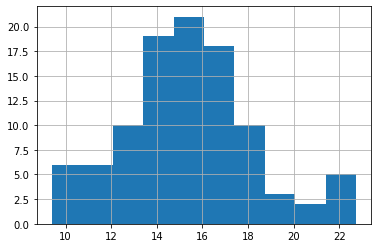

In [12]:
pd.Series(scores).hist()

In [13]:
print('extreme in search space', ' - ', (1 + (pd.Series(scores) > 43.9178).mean())/101)

extreme in search space  -  0.009900990099009901


In [14]:
pd.DataFrame([[sub, sc] for sub, sc in zip(subsets, scores)]).to_csv('../results/education_power.csv', index = False)